<a href="https://colab.research.google.com/github/jkranyak/705_MBA_FinalPaper/blob/main/705_MBA_FinalPaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openai==0.28
!pip install nltk gensim matplotlib scikit-learn pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 4.7 MB/s eta 0:00:00


In [2]:
!pip install orange3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.2/516.2 kB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.1/264.1 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 87.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 107.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━

In [4]:
# Standard library imports
import os
import re
from collections import Counter, defaultdict
import requests
from bs4 import BeautifulSoup

# Third-party library imports for data manipulation
import pandas as pd

# Imports for text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Imports for machine learning and data visualization
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Other third-party libraries
import Orange
import openai

# Google Colab specific library
from google.colab import drive

#other libraries
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel


## Code Explanation

The script performs several key steps to preprocess text data and perform topic modeling on a dataset of articles:

- Download necessary NLTK resources (stopwords, wordnet, punkt).
- Initialize the WordNet Lemmatizer for lemmatizing words.
- Define a function `preprocess_text` to convert text to lowercase, remove digits, punctuation, and extra whitespace.
- Define a function `lemmatize_tokens` to lemmatize the tokens using the WordNet Lemmatizer.
- Create a custom tokenizer `tokenize` that preprocesses the text, tokenizes it, and then lemmatizes the tokens.
- Load the dataset from a CSV file and clean the column names.
- Prepare a list of custom stopwords to exclude common and specific terms from the analysis.
- Extract text data from the 'Full article' column and use `CountVectorizer` to create a document-term matrix (DTM) with the custom tokenizer and stopwords.
- Convert the DTM to a Gensim corpus for topic modeling.
- Define a function `compute_coherence_values` to evaluate the coherence of topic models for different numbers of topics.
- Determine the optimal number of topics by computing coherence scores for models with different numbers of topics.
- Display the topics from the optimal model, showing the top words in each topic.
- Create a new DataFrame with the processed data and save it to a CSV file.


In [5]:
# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    return text.strip()

# Function to lemmatize tokens
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Custom tokenizer for CountVectorizer that incorporates preprocessing and lemmatization
def tokenize(text):
    text = preprocess_text(text)
    tokens = nltk.word_tokenize(text)
    return lemmatize_tokens(tokens)

# Load the data
df = pd.read_csv("/content/AI Meta analysis .csv")

# Clean the column names
df.columns = df.columns.str.strip()

# Check if the 'Full article' column is present after cleaning
if 'Full article' not in df.columns:
    raise KeyError("'Full article' column not found even after cleaning.")

# Prepare custom stopwords
custom_stopwords = list(set(stopwords.words('english')) | {
    "artificial intelligence", "ai", 'xai', 'also', 'global', 'international',
    "global organizations", "corporate", 'strategies', 'organizational', 'policy',
    "impact", "effect", "consequence", "influence", "decision",
    "qualitative research", "meta-analysis", "thematic analysis", "machine learning",
    "deep learning", "automation", "et", "al", "business", "organization", "organisation",
    "strategic", "study", "management", 'organisational', 'decisionmaking', "devlopment",
    'eg', "aiml"
})

# Prepare the text data
texts = df["Full article"].tolist()
vectorizer = CountVectorizer(tokenizer=tokenize, max_df=0.95, min_df=2, stop_words=custom_stopwords)
dtm = vectorizer.fit_transform(texts)
feature_names = vectorizer.get_feature_names_out()

# Convert DTM to gensim corpus
corpus = gensim.matutils.Sparse2Corpus(dtm, documents_columns=False)
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

# Function to compute coherence score
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1, passes=10):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                random_state=42,
                                                passes=passes,
                                                iterations=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Determine the optimal number of topics
texts_tokenized = [tokenize(text) for text in texts]
dictionary = corpora.Dictionary(texts_tokenized)

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus,
                                                        texts=texts_tokenized, start=2, limit=10, step=1, passes=20)

# Print coherence scores
for m, cv in zip(range(2, 10, 1), coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

# Select the model with the highest coherence score
optimal_model = model_list[coherence_values.index(max(coherence_values))]
optimal_num_topics = coherence_values.index(max(coherence_values)) + 2

# Display topics
for index, topic in enumerate(optimal_model.print_topics(num_words=10)):
    print(f"Topic #{index}: {topic}")

# Create a new DataFrame with the processed data
processed_df = pd.DataFrame(dtm.toarray(), columns=feature_names)

# Save the processed DataFrame to a CSV file (if needed)
processed_df.to_csv("/content/Processed_AI_Meta_Analysis.csv", index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['analysis', 'arent', 'artificial', 'couldnt', 'deep', 'didnt', 'doe', 'doesnt', 'dont', 'ha', 'hadnt', 'hasnt', 'havent', 'intelligence', 'isnt', 'learning', 'machine', 'metaanalysis', 'mightnt', 'mustnt', 'neednt', 'qualitative', 'research', 'shant', 'shes', 'shouldnt', 'shouldve', 'strategy', 'thatll', 'thematic', 'wa', 'wasnt', 'w

Num Topics = 2  has Coherence Value of 0.7361
Num Topics = 3  has Coherence Value of 0.6758
Num Topics = 4  has Coherence Value of 0.7072
Num Topics = 5  has Coherence Value of 0.7006
Num Topics = 6  has Coherence Value of 0.7147
Num Topics = 7  has Coherence Value of 0.6911
Num Topics = 8  has Coherence Value of 0.7051
Num Topics = 9  has Coherence Value of 0.7034
Topic #0: (0, '0.007*"incubator" + 0.007*"júnior" + 0.006*"corporation" + 0.005*"out" + 0.005*"descriptive" + 0.005*"distracted" + 0.005*"displacement" + 0.005*"storing" + 0.005*"respectively" + 0.004*"why"')
Topic #1: (1, '0.009*"constructed" + 0.008*"distracted" + 0.007*"preventing" + 0.006*"storing" + 0.006*"incubator" + 0.005*"national" + 0.004*"timing" + 0.004*"geographical" + 0.004*"memory" + 0.004*"optimism"')


## Code Explanation

This script preprocesses text data, applies topic modeling using Latent Dirichlet Allocation (LDA), and processes the results. Here are the steps involved:


- **Preparation is the same as previous cell block**
  
- **Applying LDA**:
  Applies Latent Dirichlet Allocation (LDA) with `n_components=2` to the DTM to identify topics in the text data.

- **Displaying Topics**:
  Displays the top words for each identified topic by iterating through the LDA model components.

- **Creating a Processed DataFrame**:
  Creates a new DataFrame with the processed data from the DTM and saves it to a CSV file.

In [6]:
# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    return text.strip()

# Function to lemmatize tokens
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Custom tokenizer for CountVectorizer that incorporates preprocessing and lemmatization
def tokenize(text):
    text = preprocess_text(text)
    tokens = nltk.word_tokenize(text)
    return lemmatize_tokens(tokens)

# Load the data
df = pd.read_csv("/content/AI Meta analysis .csv")

# Clean the column names
df.columns = df.columns.str.strip()

# Check if the 'Full article' column is present after cleaning
if 'Full article' not in df.columns:
    raise KeyError("'Full article' column not found even after cleaning.")

# Prepare custom stopwords
custom_stopwords = list(set(stopwords.words('english')) | {
    "artificial intelligence", "ai", 'xai', 'also', 'global', 'international',
    "global organizations", "corporate", 'strategies', 'organizational', 'policy',
    "impact", "effect", "consequence", "influence", "decision",
    "qualitative research", "meta-analysis", "thematic analysis", "machine learning",
    "deep learning", "automation", "et", "al", "business", "organization", "organisation",
    "strategic", "study", "management", 'organisational', 'decisionmaking', "devlopment",
    'eg', "aiml",  "wa", "r", "may", "could"
})

# Prepare the text data
texts = df["Full article"].tolist()
vectorizer = CountVectorizer(tokenizer=tokenize, max_df=0.95, min_df=2, stop_words=custom_stopwords)
dtm = vectorizer.fit_transform(texts)

# Apply LDA
lda_model = LatentDirichletAllocation(n_components=2, random_state=42)
lda_model.fit(dtm)

# Display topics
for index, topic in enumerate(lda_model.components_):
    print(f"Topic #{index}:")
    print([vectorizer.get_feature_names_out()[I] for I in topic.argsort()[-10:]])

# Create a new DataFrame with the processed data
processed_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

# Save the processed DataFrame to a CSV file (if needed)
processed_df.to_csv("/content/Processed_AI_Meta_Analysis.csv", index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['analysis', 'arent', 'artificial', 'couldnt', 'deep', 'didnt', 'doe', 'doesnt', 'dont', 'ha', 'hadnt', 'hasnt', 'havent', 'intelligence', 'isnt', 'learning', 'machine', 'metaanalysis', 'mightnt', 'mustnt', 'neednt', 'qualitative', 'research', 'shant', 'shes', 'shouldnt

Topic #0:
['development', 'analysis', 'innovation', 'resource', 'human', 'financial', 'risk', 'model', 'firm', 'performance']
Topic #1:
['algorithm', 'task', 'development', 'example', 'work', 'worker', 'firm', 'change', 'new', 'human']


## Code Explanation

This block of code generates word clouds for each identified topic from the LDA model. Word clouds visually represent the most important words in each topic, with word size indicating frequency.

- **Generating Word Clouds for Each Topic**:
  - The code iterates over each topic in the LDA model.
  - For each topic, it creates a new figure.
  - It extracts the top words and their frequencies for each topic.
  - A word cloud is generated using these word frequencies.
  - The word cloud is displayed with no axis, and a title indicating the topic number is added.

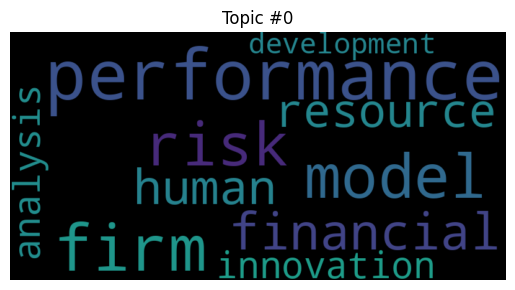

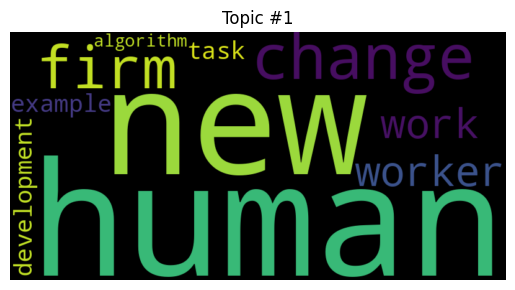

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate word clouds for each topic
for index, topic in enumerate(lda_model.components_):
    plt.figure()
    word_freqs = {vectorizer.get_feature_names_out()[i]: topic[i] for i in topic.argsort()[-10:]}
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freqs)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic #{index}")
    plt.show()


## Code Explanation

This script preprocesses text data, applies topic modeling using Latent Dirichlet Allocation (LDA), and processes the results. Here's a detailed breakdown of the steps:

- **Downloading Necessary NLTK Resources**:
  - The script begins by ensuring that the required NLTK resources (`stopwords`, `wordnet`, `punkt`) are downloaded.

- **Preparing The Same as Previous cells**:

- **Applying LDA**:
  - Latent Dirichlet Allocation (LDA) is applied with `n_components=6` to the DTM to identify topics in the text data.

- **Displaying Topics**:
  - The top words for each identified topic are displayed by iterating through the LDA model components.

- **Creating a Processed DataFrame**:
  - A new DataFrame is created with the processed data from the DTM and saved to a CSV file for further use or analysis.

In [8]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    return text.strip()

# Function to lemmatize tokens
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Custom tokenizer for CountVectorizer that incorporates preprocessing and lemmatization
def tokenize(text):
    text = preprocess_text(text)
    tokens = nltk.word_tokenize(text)
    return lemmatize_tokens(tokens)

# Load the data
df = pd.read_csv("/content/AI Meta analysis .csv")

# Clean the column names
df.columns = df.columns.str.strip()

# Check if the 'Full article' column is present after cleaning
if 'Full article' not in df.columns:
    raise KeyError("'Full article' column not found even after cleaning.")

# Prepare custom stopwords
custom_stopwords = list(set(stopwords.words('english')) | {
    "artificial intelligence", "ai", 'xai', 'also', 'global', 'international',
    "global organizations", "corporate", 'strategies', 'organizational', 'policy',
    "impact", "effect", "consequence", "influence", "decision",
    "qualitative research", "meta-analysis", "thematic analysis", "machine learning",
    "deep learning", "automation", "et", "al", "business", "organization", "organisation",
    "strategic", "study", "management", 'organisational', 'decisionmaking', "devlopment",
    'eg', "aiml",  "wa", "r", "may", "could", "h", "aic"
})

# Prepare the text data
texts = df["Full article"].tolist()
vectorizer = CountVectorizer(tokenizer=tokenize, max_df=0.95, min_df=2, stop_words=custom_stopwords)
dtm = vectorizer.fit_transform(texts)

# Apply LDA
lda_model = LatentDirichletAllocation(n_components=6, random_state=42)
lda_model.fit(dtm)

# Display topics
for index, topic in enumerate(lda_model.components_):
    print(f"Topic #{index}:")
    print([vectorizer.get_feature_names_out()[I] for I in topic.argsort()[-10:]])

# Create a new DataFrame with the processed data
processed_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

# Save the processed DataFrame to a CSV file (if needed)
processed_df.to_csv("/content/Processed_AI_Meta_Analysis.csv", index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['analysis', 'arent', 'artificial', 'couldnt', 'deep', 'didnt', 'doe', 'doesnt', 'dont', 'ha', 'hadnt', 'hasnt', 'havent', 'intelligence', 'isnt', 'learning', 'machine', 'metaanalysis', 'mightnt', 'mustnt', 'neednt', 'qualitative', 'research', 'shant', 'shes', 'shouldnt

Topic #0:
['bias', 'accountability', 'issue', 'regulatory', 'sector', 'framework', 'transparency', 'risk', 'model', 'financial']
Topic #1:
['industry', 'challenge', 'analysis', 'integration', 'model', 'role', 'sustainable', 'development', 'human', 'risk']
Topic #2:
['sector', 'state', 'new', 'standard', 'approach', 'rd', 'national', 'development', 'public', 'government']
Topic #3:
['definition', 'researcher', 'category', 'framework', 'article', 'machine', 'group', 'application', 'making', 'human']
Topic #4:
['activity', 'work', 'theme', 'value', 'employee', 'legal', 'example', 'culture', 'initiative', 'change']
Topic #5:
['digital', 'relationship', 'new', 'resource', 'innovation', 'human', 'job', 'worker', 'performance', 'firm']


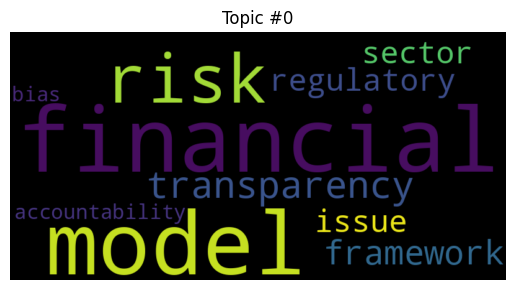

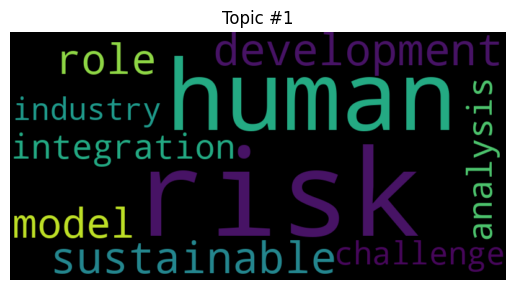

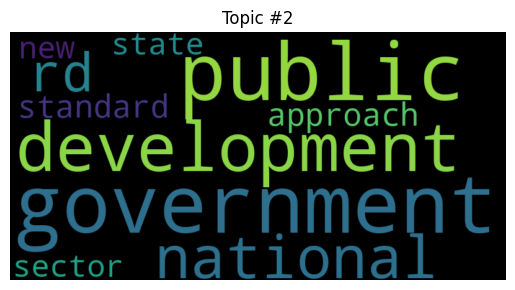

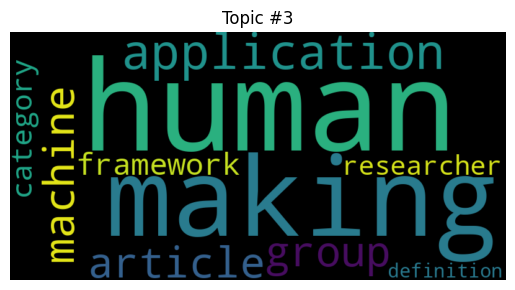

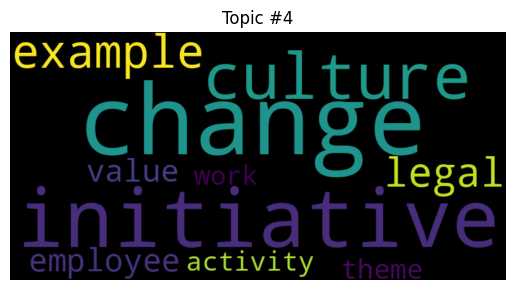

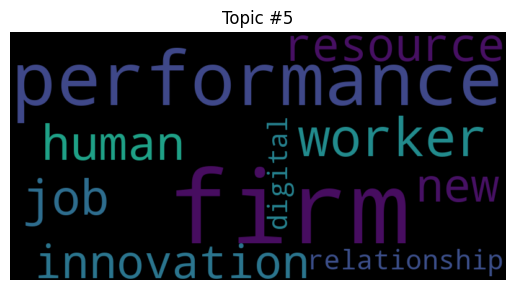

In [9]:
# Generate word clouds for each topic
for index, topic in enumerate(lda_model.components_):
    plt.figure()
    word_freqs = {vectorizer.get_feature_names_out()[i]: topic[i] for i in topic.argsort()[-10:]}
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freqs)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic #{index}")
    plt.show()

## New Steps Explanation

This section covers additional steps that are not previously explained, focusing on the implementation of Non-Negative Matrix Factorization (NMF) for topic modeling.

- **Downloading Additional NLTK Resource**:
  - The script downloads `omw-1.4` to ensure all necessary NLTK resources are available.

- **Applying NMF**:
  - Non-Negative Matrix Factorization (NMF) is applied to the document-term matrix (DTM) with `n_components=6` to identify topics in the text data.
  - `W` represents the document-topic matrix.
  - `H` represents the topic-term matrix.

- **Displaying Topics**:
  - The top words for each identified topic are displayed by iterating through the components of the NMF model (`H`).

In [10]:
# Ensure necessary NLTK resources are downloaded
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
import pandas as pd
import re

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize tokens
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Custom tokenizer for CountVectorizer that incorporates lemmatization
def tokenize(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    tokens = nltk.word_tokenize(text)
    return lemmatize_tokens(tokens)

# Load the data
df = pd.read_csv("/content/AI Meta analysis .csv")

# Clean the column names
df.columns = df.columns.str.strip()

# Check if the 'Full article' column is present after cleaning
if 'Full article' not in df.columns:
    raise KeyError("'Full article' column not found even after cleaning.")

# Prepare custom stopwords
custom_stopwords = list(set(stopwords.words('english')) | {
    "artificial intelligence", "ai", 'xai', 'also', 'global', 'international',
    "global organizations", "corporate", 'strategies', 'organizational', 'policy',
    "impact", "effect", "consequence", "influence", "decision",
    "qualitative research", "meta-analysis", "thematic analysis", "machine learning",
    "deep learning", "automation", "et", "al", "business", "organization", "organisation",
    "strategic", "study", "management", 'organisational', 'decisionmaking', "devlopment",
    'eg', "aiml",  "wa", "r", "may", "could", "h", "aic", "p"
})

# Prepare the text data
texts = df["Full article"].tolist()
vectorizer = CountVectorizer(tokenizer=tokenize, max_df=0.95, min_df=2, stop_words=custom_stopwords)
dtm = vectorizer.fit_transform(texts)

# Apply NMF
nmf_model = NMF(n_components=6, random_state=42)
W = nmf_model.fit_transform(dtm)
H = nmf_model.components_

# Display topics
for index, topic in enumerate(H):
    print(f"Topic #{index}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['analysis', 'arent', 'artificial', 'couldnt', 'deep', 'didnt', 'doe', 'doesnt', 'dont', 'ha', 'hadnt', 'hasnt', 'havent', 'intelligence', 'isnt', 'learning', 'machine', 'metaanalysis', 'mightnt', 'mustnt', '

Topic #0:
['human', 'developing', 'partnership', 'model', 'needed', 'federal', 'government', 'standard', 'development', 'rd']
Topic #1:
['finding', 'model', 'capability', 'financial', 'operational', 'relationship', 'resource', 'innovation', 'firm', 'performance']
Topic #2:
['percent', 'warehousing', 'new', 'hiring', 'algorithm', 'labor', 'task', 'job', 'firm', 'worker']
Topic #3:
['assessment', 'capability', 'approach', 'effectiveness', 'financial', 'model', 'analysis', 'image', 'human', 'risk']
Topic #4:
['researcher', 'computer', 'group', 'category', 'framework', 'article', 'machine', 'application', 'making', 'human']
Topic #5:
['new', 'industry', 'initiative', 'challenge', 'sustainability', 'role', 'sustainable', 'model', 'development', 'change']


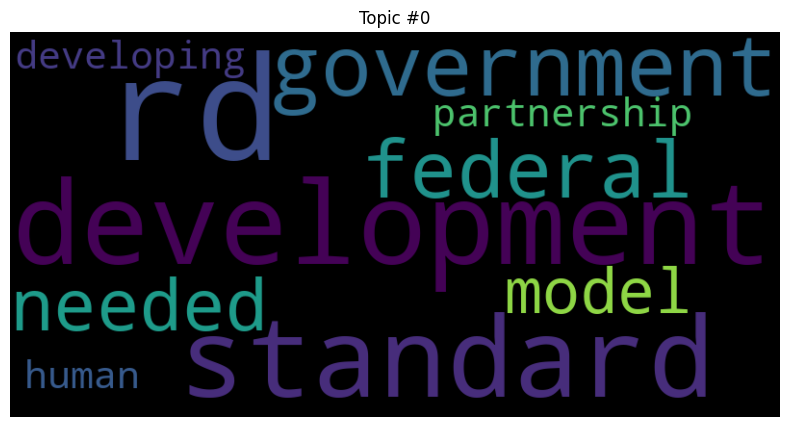

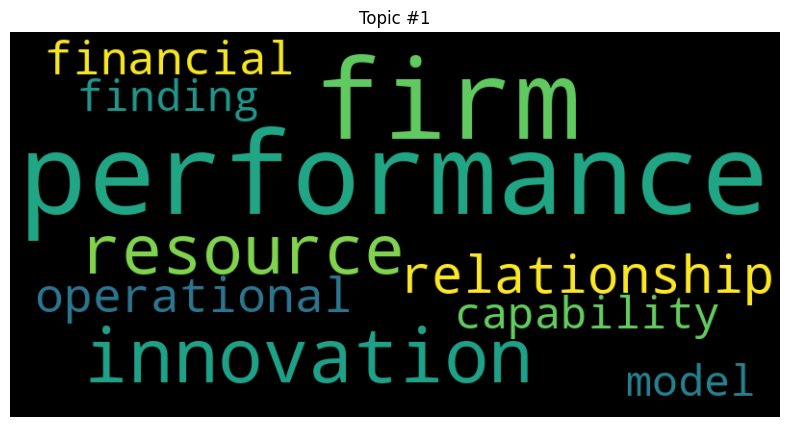

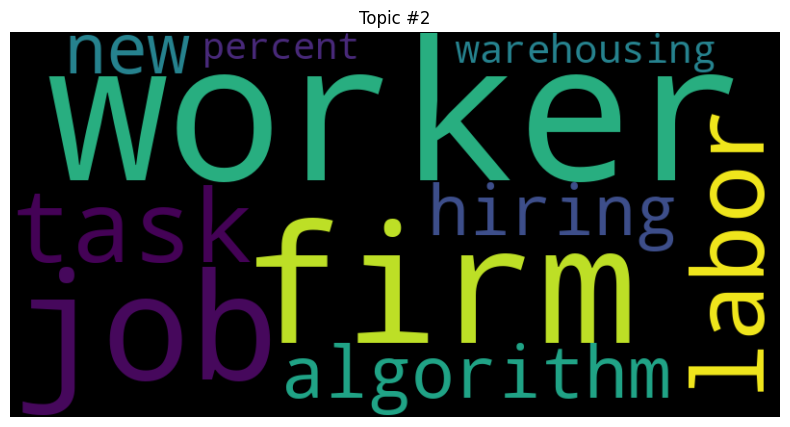

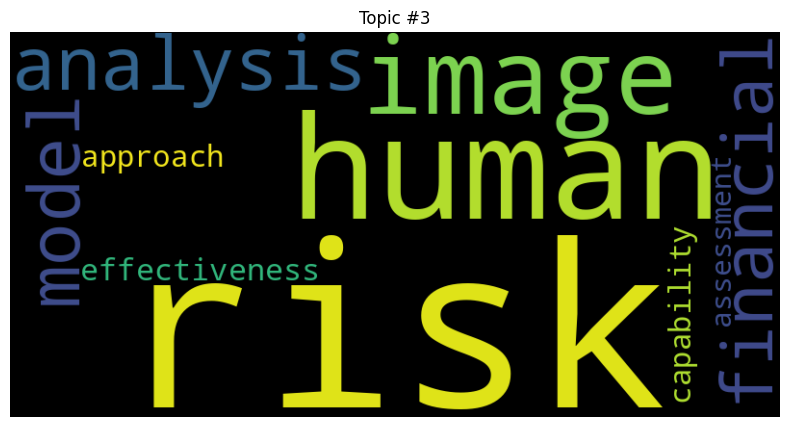

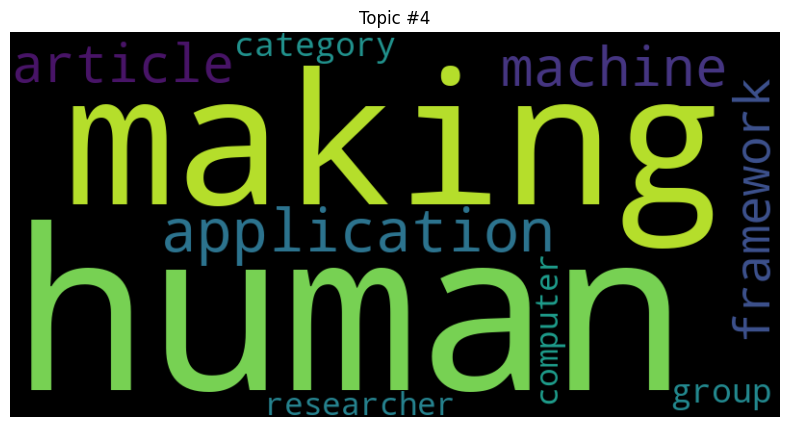

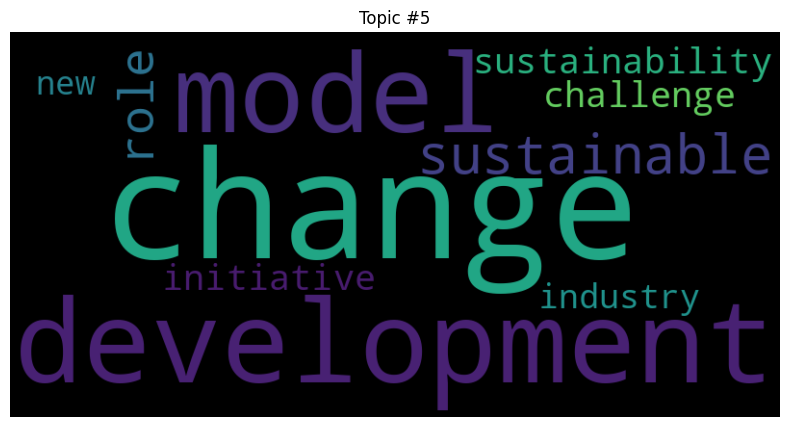

In [11]:
# Generate word clouds for each topic from the NMF model
for index, topic in enumerate(nmf_model.components_):
    plt.figure(figsize=(10, 5))
    # Generate word frequencies for the top words in this topic
    word_freqs = {vectorizer.get_feature_names_out()[i]: topic[i] for i in topic.argsort()[-10:]}
    # Create a WordCloud visualization
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freqs)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic #{index}")
    plt.show()


In [12]:
# Install necessary packages
!pip install nltk gensim matplotlib scikit-learn pyLDAvis pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.3 MB/s eta 0:00:00


## AI Agent Team Setup

This section covers the new steps introduced in the code, focusing on loading and verifying the API key, usng AI Agents for summarizing articles, analyzing summaries, and compiling a final report.

- **Function to Load and Verify the API Key**:
  - A function `load_api_key` is defined to read the API key from a file, check its format, and return the key.

- **Loading and Setting the API Key**:
  - The API key is loaded using `load_api_key` and set for OpenAI.

- **Loading the CSV File Containing Articles**:
  - The CSV file with articles is loaded into a DataFrame.

- **Function to Summarize an Article**:
  - Defines `summarize_article` to generate a concise summary of an article using the OpenAI API.

- **Function to Analyze an Article Summary**:
  - Defines `analyze_summary` to analyze a summary, identify key thematic elements, research gaps, methodologies used, and conclusions.

- **Function to Process Summaries in Batches**:
  - Defines `process_summaries` to process articles in batches, generating summaries for each batch.

- **Function to Analyze Summaries in Batches**:
  - Defines `process_analyses` to analyze summaries in batches, considering different research roles.

- **Function to Aggregate Thematic Elements**:
  - Defines `aggregate_thematic_elements` to synthesize thematic elements from multiple analyses into a concise summary.

- **Function to Compile the Final Report**:
  - Defines `compile_report` to create a comprehensive report from the aggregated thematic elements.

- **Manager Function to Control Workflow**:
  - Defines `manager` to control the workflow: process summaries, analyze them, aggregate thematic elements, compile the final report, and save it to a file.

- **Execution of the Manager Function**:
  - The `manager` function is called to run the entire process, generating and saving the meta-analysis report.


In [15]:
# Install necessary libraries
!pip install openai pandas

# Import required libraries
import openai
import pandas as pd
import time


In [19]:
# Function to load and verify the API key
def load_api_key(filepath):
    with open(filepath, 'r') as file:
        line = file.read().strip()
        if '=' in line:
            key = line.split('=')[1].strip().strip("'")
            return key
        else:
            raise ValueError("The API key format is incorrect. Please check the key in the file.")

# Load the API key from the file
api_key = load_api_key('/content/OPENAI_API.txt')

# Set the API key for OpenAI
openai.api_key = api_key

# Load the CSV file containing the articles
articles_df = pd.read_csv('/content/AI Meta analysis .csv')

# Function to summarize articles with retry mechanism
def summarize_articles(articles, model="gpt-3.5-turbo"):
    summaries = []
    for article in articles:
        messages = [
            {"role": "system", "content": "You are an expert at summarizing long articles into concise summaries."},
            {"role": "user", "content": f"Please summarize the following article in 50 words or less:\n\n{article}"}
        ]

        max_retries = 5
        retry_delay = 1
        for attempt in range(max_retries):
            try:
                response = openai.ChatCompletion.create(
                    model=model,
                    messages=messages,
                    max_tokens=100,
                    n=1,
                    stop=None,
                    temperature=0.5,
                )
                summaries.append(response.choices[0].message['content'].strip())
                break
            except openai.error.RateLimitError as e:
                retry_after = e.headers.get("Retry-After", retry_delay)
                print(f"Rate limit error: {e}. Waiting for {retry_after} seconds before retrying... (Attempt {attempt + 1}/{max_retries})")
                time.sleep(float(retry_after))
            except openai.error.InvalidRequestError as e:
                print(f"Invalid request error: {e}. Reducing the size of the messages.")
                messages[1]['content'] = f"Please summarize the following article in 30 words or less:\n\n{article[:500]}"
                response = openai.ChatCompletion.create(
                    model=model,
                    messages=messages,
                    max_tokens=60,
                    n=1,
                    stop=None,
                    temperature=0.5,
                )
                summaries.append(response.choices[0].message['content'].strip())
                break
        else:
            raise Exception("Max retries exceeded for summarizing articles.")
    return summaries

# Function to extract thematic elements and methodologies
def extract_thematic_elements(summaries, model="gpt-3.5-turbo"):
    thematic_elements = []
    for summary in summaries:
        messages = [
            {"role": "system", "content": "You are a professional researcher extracting key themes, methodologies, and conclusions from an article summary."},
            {"role": "user", "content": f"Please extract the key thematic elements, research gaps, methodologies used, and conclusions drawn from the following article summary:\n\n{summary}"}
        ]

        max_retries = 5
        retry_delay = 1
        for attempt in range(max_retries):
            try:
                response = openai.ChatCompletion.create(
                    model=model,
                    messages=messages,
                    max_tokens=150,
                    n=1,
                    stop=None,
                    temperature=0.7,
                )
                thematic_elements.append(response.choices[0].message['content'].strip())
                break
            except openai.error.RateLimitError as e:
                retry_after = e.headers.get("Retry-After", retry_delay)
                print(f"Rate limit error: {e}. Waiting for {retry_after} seconds before retrying... (Attempt {attempt + 1}/{max_retries})")
                time.sleep(float(retry_after))
        else:
            raise Exception("Max retries exceeded for extracting thematic elements.")
    return thematic_elements

# Function to process articles and extract information
def process_articles(articles, model="gpt-3.5-turbo"):
    summaries = summarize_articles(articles, model=model)
    thematic_elements = extract_thematic_elements(summaries, model=model)
    return summaries, thematic_elements

# Function to compile the final report
def compile_report(summaries, thematic_elements):
    report = "Meta-Analysis Report\n\n"
    report += "This report provides a comprehensive synthesis of thematic elements from the articles reviewed by various experts in the field of organizational processes and AI.\n\n"

    for i, (summary, thematic_element) in enumerate(zip(summaries, thematic_elements)):
        report += f"Article {i+1} Summary:\n{summary}\n\n"
        report += f"Article {i+1} Thematic Elements:\n{thematic_element}\n\n"

    return report

# Manager to control the agents and workflow
def manager(articles_df, model="gpt-3.5-turbo"):
    articles = articles_df['Full article '].tolist()

    # Process articles in batches
    summaries, thematic_elements = [], []
    batch_size = 3
    for i in range(0, len(articles), batch_size):
        batch_summaries, batch_thematic_elements = process_articles(articles[i:i+batch_size], model=model)
        summaries.extend(batch_summaries)
        thematic_elements.extend(batch_thematic_elements)

    # Compile the final report
    report = compile_report(summaries, thematic_elements)

    # Save the report to a text file
    report_file_path = '/content/meta_analysis_report.txt'
    with open(report_file_path, 'w') as report_file:
        report_file.write(report)

    print(f"Meta-analysis report saved to {report_file_path}")

# Execute the manager function to run the entire process
manager(articles_df)


Rate limit error: Rate limit reached for gpt-3.5-turbo in organization org-CTiuD1Qi8ljSERa67MqDz4Qz on tokens per min (TPM): Limit 60000, Used 42988, Requested 21355. Please try again in 4.343s. Visit https://platform.openai.com/account/rate-limits to learn more.. Waiting for 5 seconds before retrying... (Attempt 1/5)
Invalid request error: This model's maximum context length is 16385 tokens. However, your messages resulted in 17521 tokens. Please reduce the length of the messages.. Reducing the size of the messages.
Rate limit error: Rate limit reached for gpt-3.5-turbo in organization org-CTiuD1Qi8ljSERa67MqDz4Qz on tokens per min (TPM): Limit 60000, Used 49600, Requested 11495. Please try again in 1.095s. Visit https://platform.openai.com/account/rate-limits to learn more.. Waiting for 2 seconds before retrying... (Attempt 1/5)
Rate limit error: Rate limit reached for gpt-3.5-turbo in organization org-CTiuD1Qi8ljSERa67MqDz4Qz on tokens per min (TPM): Limit 60000, Used 54608, Request



---



In [27]:
# Install necessary libraries
!pip install openai

# Import necessary libraries
import openai

# Function to load the initial report from the file
def load_initial_report(filepath):
    # Read the content of the initial report from the specified file path
    with open(filepath, 'r') as file:
        return file.read()

# Function to refine the report using GPT-4 Omni
def refine_report(initial_report, model="gpt-4o"):
    # Define the messages for the GPT-4 Omni model
    messages = [
        {"role": "system", "content": "You are an expert editor. Please refine the following report for clarity and conciseness, focusing on synthesizing overarching themes, research gaps, and conclusions."},
        {"role": "user", "content": f"You are a Masters level student in an MBA program conducting a Meta-Analys for the 'Impact of Artificial Intelligence on Global Organizational Strategies and Policy'. Keep the title in mind and do not make redundant themes for the title. Please refine the following report for clarity and conciseness:\n\n{initial_report}"}
    ]
    # Call the OpenAI API to refine the report
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        max_tokens=3000,
        n=1,
        stop=None,
        temperature=0.5,
    )
    # Return the refined content
    return response.choices[0].message['content'].strip()

# Function to load the API key from the file
def load_api_key(filepath):
    # Read the API key from the specified file path
    with open(filepath, 'r') as file:
        line = file.read().strip()
        if '=' in line:
            key = line.split('=')[1].strip().strip("'")
            return key
        else:
            raise ValueError("The API key format is incorrect. Please check the key in the file.")

# Load the API key
api_key = load_api_key('/content/OPENAI_API.txt')

# Set the API key for OpenAI
openai.api_key = api_key

# Load the initial report
initial_report = load_initial_report('/content/meta_analysis_report.txt')

# Refine the report
refined_report = refine_report(initial_report)

# Save the refined report to a text file
refined_report_file_path = '/content/refined_meta_analysis_report.txt'
with open(refined_report_file_path, 'w') as report_file:
    report_file.write(refined_report)

print(f"Refined meta-analysis report saved to {refined_report_file_path}")


Refined meta-analysis report saved to /content/refined_meta_analysis_report.txt


In [4]:
import pandas as pd
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Load the CSV file
file_path = '/content/Combined_data.csv'
data = pd.read_csv(file_path)

# Clean and inspect column names
data.columns = data.columns.str.strip().str.replace('\n', '')
print("Column names after cleaning:", data.columns.tolist())

# Function to preprocess text: tokenize, convert to lowercase, and remove punctuation
def preprocess_text_simple(text):
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text

# Apply simple preprocessing to the themes
data['Human_processed'] = data['Human'].apply(preprocess_text_simple)
data['LDA_processed'] = data['LDA'].apply(preprocess_text_simple)
data['NMF_processed'] = data['NMF'].apply(preprocess_text_simple)
data['AI Agents_processed'] = data['AI Agents'].apply(preprocess_text_simple)

# Combine all preprocessed themes into one list
all_processed_themes = pd.concat([data[col] for col in ['Human_processed', 'LDA_processed', 'NMF_processed', 'AI Agents_processed']], axis=0)

# Vectorize the themes
vectorizer = TfidfVectorizer()
theme_vectors = vectorizer.fit_transform(all_processed_themes)

# Use clustering to identify unique thematic groups
kmeans = KMeans(n_clusters=10, random_state=42)  # Adjust the number of clusters based on the thematic diversity
kmeans.fit(theme_vectors)

# Analyze the results
clustered_themes = pd.DataFrame({
    'Theme': all_processed_themes,
    'Cluster': kmeans.labels_
})

# Display clustered themes to explore unique thematic groups
clustered_results = clustered_themes.groupby('Cluster')['Theme'].apply(list)
print(clustered_results)

Column names after cleaning: ['Human', 'LDA', 'NMF', 'AI Agents']
Cluster
0    [national and public sector approaches\n, busi...
1    [strategy and competition\n, governance and re...
2         [ethics, corporate governance and ethics \n]
3    [regulatory and ethical issues\n, regulatory a...
4    [human resources and culture\n, research frame...
5    [financial and operational performance, financ...
6    [industry challenges and integration, industry...
7    [safety security and risk management\n, risk a...
8                                  [decision making\n]
9                                  [decisionmaking \n]
Name: Theme, dtype: object
